# *CoNNear*: A convolutional neural-network model of human cochlear mechanics and filter tuning for real-time applications

Python notebook for reproducing the evaluation results of the proposed CoNNear model.

## Prerequisites

- First, let us compile the cochlea_utils.c file that is used for solving the transmission line (TL) model of the cochlea. This requires some C++ compiler which should be installed beforehand. Then go the connear folder from the terminal and run:
```  
gcc -shared -fpic -O3 -ffast-math -o tridiag.so cochlea_utils.c  
```
- Install numpy, scipy, keras and tensorflow

- If running on google colab: add the following as a code block and run it to compile cochlea_utils.c in the runtime machine.
```
!gcc -shared -fpic -O3 -ffast-math -o tridiag.so cochlea_utils.c
```

## Import required python packages and functions
Import required python packages and load the connear model.

In [1]:
import os
#os.add_dll_directory(os.getcwd())

import numpy as np
from scipy import signal
import scipy.signal as sp_sig
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

from tlmodel.get_tl_vbm_and_oae import tl_vbm_and_oae
from helper_ops import *

json_file = open("connear/Gmodel.json", "r")
loaded_model_json = json_file.read()
json_file.close()
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):    
    connear = model_from_json(loaded_model_json)
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
     connear.load_weights("connear/Gmodel.h5")
connear.summary()

Using TensorFlow backend.
/Users/staralfur/anaconda/envs/ML_TF/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/staralfur/anaconda/envs/ML_TF/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/staralfur/anaconda/envs/ML_TF/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/staralf

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_input (InputLayer)     (None, None, 1)           0         
_________________________________________________________________
model_1 (Model)              (None, None, 201)         11689984  
Total params: 11,689,984
Trainable params: 11,689,984
Non-trainable params: 0
_________________________________________________________________


Define parameters


In [2]:
# Define model specific variables
down_rate = 2
fs = 20e3
fs_tl = 100e3
factor_fs = int(fs_tl / fs)
p0 = 2e-5
right_context = 256
left_context = 256
# load CFs 
CF = np.loadtxt('tlmodel/cf.txt')
channels = CF.size 

## Click response
Compare the responses of the models to a click stimulus.      
**Notice that for all the simulations, TL model operates at 100kHz and the CoNNear model operates at 20kHz.**

In [3]:
#Define the click stimulus
dur = 128.0e-3 # for 2560 samples (2048 window length, 2x256 context)
stim = np.zeros((1, int(dur * fs)))
L = 70.0
samples = dur * fs
click_duration = 2 # 100 us click
click_duration_tl = factor_fs * click_duration  
silence = 60 #samples in silence
samples = int(samples - right_context - left_context)

################# TL ##########################################
stim = np.zeros((1, (samples + right_context + left_context)*factor_fs))
stim[0, (factor_fs * (right_context+silence)) : (factor_fs * (right_context+silence)) + click_duration_tl] = 2 * np.sqrt(2) * p0 * 10**(L/20)

output = tl_vbm_and_oae(stim , L)
CF_tl_full = output[0]['cf']
channels_tl = CF_tl_full.size
CF_tl = CF_tl_full[::down_rate]
# basilar membrane motion for click response, the context samples (first and last 256 samples) are removed. Also downsample it to 20kHz
bmm_click_out_full = np.array(output[0]['v'])
stimrange = range(right_context*factor_fs, (right_context*factor_fs) + (factor_fs*samples))
bmm_click_tl = sp_sig.resample_poly(output[0]['v'][stimrange,::down_rate], fs, fs_tl)
bmm_click_tl = bmm_click_tl.T 

################ CoNNear ####################################
stim = np.zeros((1, int(dur * fs)))
stim[0, right_context + silence : right_context + silence + click_duration] = 2 * np.sqrt(2) * p0 * 10**(L/20)

stim = np.expand_dims(stim, axis=2)
connear_pred_click = connear.predict(stim.T, verbose=1)
bmm_click_connear = connear_pred_click[0,:,:].T * 1e-6

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
1/1 [==============================] - 0s 313ms/step


Plotting the results.

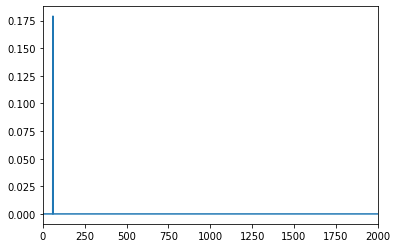

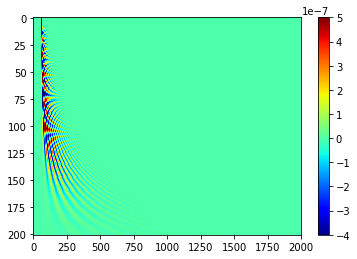

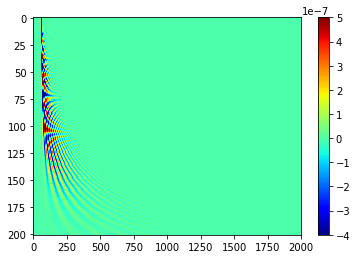

In [4]:
################ Plots ######################################
#Plot input stimulus
plt.plot(stim[0,256:-256]), plt.xlim(0,2000)
plt.show()

# Plot the TL response
plt.imshow(bmm_click_tl, aspect='auto', cmap='jet')
plt.xlim(0,2000), plt.clim(-4e-7,5e-7)
plt.colorbar()
plt.show()

# Plot the CoNNear response
plt.imshow(bmm_click_connear, aspect='auto', cmap='jet')
plt.xlim(0,2000), plt.clim(-4e-7,5e-7)
plt.colorbar()
plt.show()

## Cochlear Excitation Patterns
Here, we plot the simulated RMS levels of basilar memberane (BM) displacement across CF for tone stimuli presented at SPLs between 0 and 90 dB SPL.

**You can change the `f_tone` variable to have tone stimuli of different frequencies, say 500Hz, 1kHz, 2kHz, etc..**

In [5]:
f_tone = 1e3 # You can change this tone frequency to see how the excitation pattern changes with stimulus frequency
dur = 102.4e-3 # for 2048 samples
window_len = int(fs * dur)
L = np.arange(0., 91.0, 10.) # SPLs from 0 to 90dB
total_length = window_len + right_context + left_context #total length = 2560

################# TL ##########################################
t = np.arange(0., dur, 1./fs_tl)
hanlength = int(10e-3 * fs_tl) 
stim_sin = np.sin(2 * np.pi * f_tone * t)
han = signal.hanning(hanlength)
stim_sin[:int(hanlength/2)] = stim_sin[:int(hanlength/2)] * han[:int(hanlength/2)]
stim_sin[-int(hanlength/2):] = stim_sin[-int(hanlength/2):] * han[int(hanlength/2):]
total_length_tl = factor_fs * total_length
stim = np.zeros((len(L), total_length_tl))
for j in range(len(L)):
    stim[j, factor_fs*right_context:factor_fs*(window_len+right_context)] = p0 * np.sqrt(2) * 10**(L[j]/20) * stim_sin
output = tl_vbm_and_oae(stim, L)

tl_target_tone_full = np.zeros((len(L), total_length_tl,channels_tl))
tl_target_tone = np.zeros((len(L), window_len,channels))
stimrange = range(right_context*factor_fs, (right_context*factor_fs) + (factor_fs*samples))
for i in range(len(L)):
    tl_target_tone_full[i,:,:] = np.array(output[i]['v'])
    tl_target_tone[i,:,:] = sp_sig.resample_poly(output[i]['v'][stimrange,::down_rate], fs, fs_tl)
    tl_target_tone[i,:,:] = tl_target_tone[i,:,:] * 1e6  
tl_target_tone_rms = np.vstack([rms(tl_target_tone[i]) for i in range(len(L))])

################ CoNNear ####################################
t = np.arange(0., dur, 1./fs)
hanlength = int(10e-3 * fs) # 10ms length hanning window
stim_sin = np.sin(2 * np.pi * f_tone * t)
han = signal.windows.hann(hanlength)
stim_sin[:int(hanlength/2)] = stim_sin[:int(hanlength/2)] * han[:int(hanlength/2)]
stim_sin[-int(hanlength/2):] = stim_sin[-int(hanlength/2):] * han[int(hanlength/2):]
stim = np.zeros((len(L), total_length))
for j in range(len(L)):
    stim[j,right_context:window_len+right_context] = p0 * np.sqrt(2) * 10**(L[j]/20) * stim_sin
    
# prepare for feeding to the DNN
stim = np.expand_dims(stim, axis=2)

connear_pred_tone = connear.predict(stim, verbose=1)
bmm_tone_connear = connear_pred_tone

# Compute rms for each level
cochlear_pred_tone_rms = np.vstack([rms(bmm_tone_connear[i]) for i in range(len(L))])

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
10/10 [==============================] - 2s 197ms/step


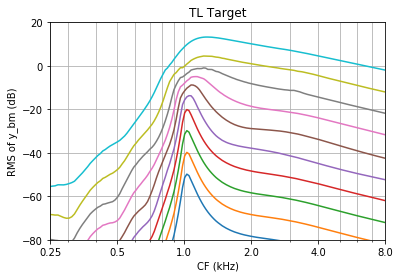

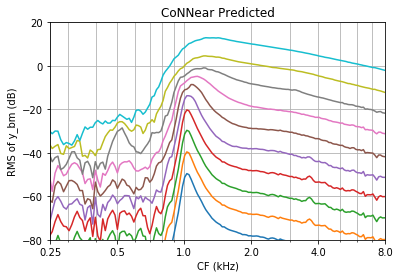

In [7]:
################ Plots ######################################
# Plot the RMS for the TL
cftile=np.tile(CF_tl, (len(L),1))
plt.semilogx((cftile.T)/10e2, 20.*np.log10(tl_target_tone_rms.T))
plt.xlim(0.25,8.), plt.grid(which='both'), 
plt.xticks(ticks=(0.25, 0.5, 1., 2., 4., 8.) , labels=(0.25, 0.5, 1., 2., 4., 8.))
plt.ylim(-80, 20)
plt.xlabel('CF (kHz)')
plt.ylabel('RMS of y_bm (dB)')
plt.title('TL Target')
plt.show()

# Plot the RMS for CoNNear
cftile=np.tile(CF, (len(L),1))
plt.semilogx((cftile.T), 20.*np.log10(cochlear_pred_tone_rms.T))
plt.xlim(0.25,8.), plt.grid(which='both'), 
plt.xticks(ticks=(0.25, 0.5, 1., 2., 4., 8.) , labels=(0.25, 0.5, 1., 2., 4., 8.))
plt.ylim(-80, 20)
plt.xlabel('CF (kHz)')
plt.ylabel('RMS of y_bm (dB)')
plt.title('CoNNear Predicted')
plt.show()

## QERB Plots

Next, the level dependent tuning properties of the cochlea based on QERB are shown. For this, we choose click stimuli at three levels 0dB, 40dB and 70dB, compute their cochlear BM response and compute QERB from it.

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done


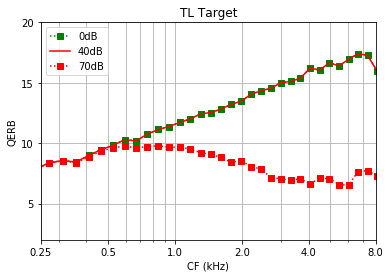

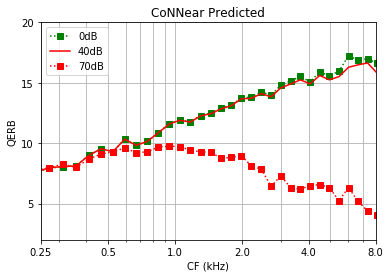

In [6]:
L = [0., 40., 70.] # We will plot it for three SPLs

################# TL ##########################################
stim_tl = np.zeros(((len(L),int(dur * fs_tl))))
QERB_tl = np.zeros(((len(L),channels_tl)))
tl_predicted = np.zeros((len(L),(window_len)*factor_fs,channels_tl))

for i in range (len(L)):
    stim_tl[i, (right_context + silence)*factor_fs : (right_context + silence + click_duration)*factor_fs] = 2 * np.sqrt(2) * p0 * 10**(L[i]/20) 

#Get TL outputs
output = tl_vbm_and_oae(stim_tl, L)

for i in range(len(L)):
    tl_predicted[i,:,:] = np.array(output[i]['v'])
    QERB_tl[i,:] = QERB_calculation(tl_predicted[i, :, :].T, CF_tl_full*1e3, fs_tl)
    
################ CoNNear ####################################
stim_con = np.zeros(((len(L),int(dur * fs)+right_context+left_context,1)))
QERB_connear = np.zeros(((len(L),channels)))

for i in range (len(L)):
    stim_con[i, right_context + silence : right_context + silence + click_duration, 0] = 2 * np.sqrt(2) * p0 * 10**(L[i]/20)
    
#Get CoNNear outputs
con_predicted = connear.predict(stim_con)

for i in range (len(L)):
    QERB_connear[i,:] = QERB_calculation(con_predicted[i, :, :].T, CF*1e3, fs)
    
################ Plots ######################################
# Plot QERB of tl model
plt.semilogx(CF_tl_full[0::10]/10e2, QERB_tl[0,0::10]/10e2,':gs', label='0dB')
plt.semilogx(CF_tl_full[0::10]/10e2, QERB_tl[1,0::10]/10e2,'r', label='40dB')
plt.semilogx(CF_tl_full[0::10]/10e2, QERB_tl[2,0::10]/10e2,':rs', label='70dB')
plt.xlim(0.25,8.), plt.grid(which='both'), 
plt.xticks(ticks=(0.25, 0.5, 1., 2., 4., 8.) , labels=(0.25, 0.5, 1., 2., 4., 8.))
plt.yticks(ticks=(5, 10, 15, 20) , labels=(5, 10, 15, 20))
plt.xlabel('CF (kHz)')
plt.ylim(2,20)
plt.ylabel('QERB')
plt.title('TL Target')
plt.legend()
plt.show()

# Plot QERB of CoNNear model
plt.semilogx(CF[0::5], (QERB_connear[0,0::5]),':gs', label='0dB')
plt.semilogx(CF[0::5], (QERB_connear[1,0::5]),'r', label='40dB')
plt.semilogx(CF[0::5], (QERB_connear[2,0::5]),':rs', label='70dB')
plt.xlim(0.25,8.), plt.grid(which='both'), 
plt.xticks(ticks=(0.25, 0.5, 1., 2., 4., 8.) , labels=(0.25, 0.5, 1., 2., 4., 8.))
plt.yticks(ticks=(5, 10, 15, 20) , labels=(5, 10, 15, 20))
plt.xlabel('CF (kHz)')
plt.ylim(2,20)
plt.ylabel('QERB')
plt.title('CoNNear Predicted')
plt.legend()
plt.show()

## Speech Input
Here, a sentence from the Dutch speech matrix (unseen during training) will be input to both the TL and the CoNNear model. By adapting fragment_length parameter, various input lengths can be compared and visualised. 

**Notice that this part is computationally more expensive with a higher fragment_duration, both in terms of memory and time.**

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done


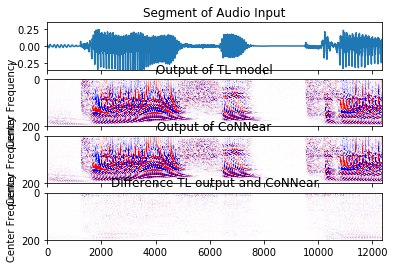

In [7]:
#load in speechfile
wavfile = 'dutch_sentence.wav'
signal_wav, fs_signal = wavfile_read(wavfile)
signalr = sp_sig.resample_poly(signal_wav, fs_tl, fs_signal)

L = np.array([70]) #sound-level of 70 dB SPL
stim_full = np.zeros((len(L), signalr.size))

for j in range(len(L)):
    stim_full[j, :] = p0 * 10**(L[j]/20) * signalr/rms(signalr)
    
fragment_length = 12345 #define fragment length (max 40000 for the included wav-file)
stim_length_init = factor_fs*(fragment_length+right_context+left_context)
stim_length = stim_length_init

#adapt fragment duration if no multiple of 16 (due to the CNN character of CoNNear, we need multiples of 16)
zero_pad = fragment_length%16
zeros = 0
if zero_pad != 0: 
    zeros = 16-zero_pad
    stim_length = factor_fs*(fragment_length+right_context+left_context+zeros)
    
################# TL ########################################## 
stim = np.zeros((len(L), int(stim_length)))
stimrange = range(0, stim_length_init)
stim[:,stimrange] = stim_full[:,0:stim_length_init]

output = tl_vbm_and_oae(stim, L)

tl_target = []
tl_target = sp_sig.resample_poly(output[0]['v'][0:,::down_rate], fs, fs_tl)
tl_target = tl_target.T * 1e6
        
################ CoNNear ####################################
stim=sp_sig.resample_poly(stim, fs, fs_tl, axis=1)
stim=np.expand_dims(stim, axis=2)

tl_pred = connear.predict(stim)
tl_pred = tl_pred[0, :, :].T

################ Plots ######################################
fig, axarr = plt.subplots(4, sharex=True)
axarr[0].set_ylim(-0.35, 0.35)
axarr[0].plot(stim[0,(left_context):-(right_context),0])
axarr[0].set_title('Segment of Audio Input')

cax1 = axarr[1].imshow(tl_target[:,left_context:-right_context], cmap='bwr',aspect='auto', vmin=-0.5, vmax=0.5)
axarr[1].set_title('Output of TL-model')
axarr[1].set(ylabel='Center Frequency')

cax2 = axarr[2].imshow(tl_pred, cmap='bwr',aspect='auto', vmin=-0.5, vmax=0.5)  
axarr[2].set_title('Output of CoNNear')
axarr[2].set(ylabel='Center Frequency')

cax3 = axarr[3].imshow(tl_pred-tl_target[:,left_context:-right_context], cmap='bwr',aspect='auto', vmin=-0.5, vmax=0.5)
axarr[3].set_title('Difference TL output and CoNNear')
axarr[3].set(ylabel='Center Frequency')

plt.show()

## DPOAE Plots
The frequency response of the 12-kHz CF channel is evaluated as a proxy for the otoacoustic emissions recorded in the ear-canal. Frequency responses of model simulations are shown in response to two pure tones of $f_{1,2}$ of 2.0 and 2.4 kHz.
The most pronounced distortion product in humans occurs at $2f_1 - f_2$ (1.6 kHz).

**Notice that this part is computationally expensive, both in terms of memory and time.**

The tone frequencies are 2000.0 and 2400.0
with levels 59.0 and 50.0
running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
6945/6945 [==============================] - 1530s 220ms/step
CF nearest to 12000.0 is 12009.824013858139


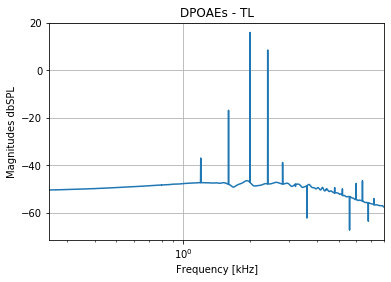

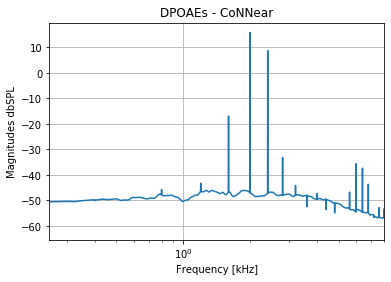

In [10]:
# Create the stimulus
L = [70.0]
f1 = 2000.
f2 = 1.2 * f1
L2 = 50.
L1 = 39 + 0.4 * L2 # scissors paradigm
print ("The tone frequencies are " + str(f1) + " and " + str(f2))
print ("with levels " + str(L1) + " and " + str(L2))
trailing_silence = 0.

# Here we will pick a stimulus longer than 2048 samples to get a better FFT
# We will prepare it with fs_tl sampling frequency
dur_sin_samples = np.lcm(int(f1), int(f2))
min_duration = 0.25 # in seconds
if dur_sin_samples < (min_duration * fs_tl):
    dur_sin = (((min_duration * fs_tl) // dur_sin_samples) + 1) * dur_sin_samples
else:
    dur_sin = dur_sin_samples
dur_sin = (dur_sin / fs_tl) 

t = np.arange(0., dur_sin, 1./fs_tl)

hanlength = int(10e-3 * fs_tl) # 10ms length hanning window
#f1
stim_sin1 = np.sin(2 * np.pi * f1 * t)
han = signal.windows.hann(hanlength)
stim_sin1 = p0 * np.sqrt(2) * 10**(L1/20) * stim_sin1
#f2
stim_sin2 = np.sin(2 * np.pi * f2 * t)
stim_sin2 = p0 * np.sqrt(2) * 10**(L2/20) * stim_sin2

stim_sin = stim_sin1 + stim_sin2

total_length =  int(trailing_silence * fs_tl) + len(stim_sin)
stim = np.zeros((1, int(total_length)))
stimrange = range(int(trailing_silence * fs_tl), int(trailing_silence * fs_tl) + len(stim_sin))
stim[0, stimrange] = stim_sin

################# TL ##########################################
output = tl_vbm_and_oae(stim , L)
tl_out_full = []
downrate = 2 # downsampling across CF axis 
tl_out_full = sp_sig.resample_poly(output[0]['v'][stimrange,::downrate], fs, fs_tl)
dpoae = sp_sig.resample_poly(output[0]['e'][stimrange,], fs, fs_tl)
tl_out_full = np.expand_dims(tl_out_full, axis=0)  

################# CoNNear ####################################
# prepare for feeding to the CoNNear model
# first resample it to fs
shift_stim = 1
stim = stim[:, :]
stim = signal.decimate(stim, factor_fs, axis=1)
stim_1 = np.array(stim[0,:])
# window the signal into chunks of 2560 samples to be fed to the CoNNer model
stim = slice_1dsignal(stim_1, 2048, shift_stim, 256, left_context=256, right_context=256)
connear_out_chunks = connear.predict(stim,verbose=1)
# undo the windowing to get back the full response
connear_out_full = undo_window (connear_out_chunks, 2048, shift_stim, ignore_first_set=0)
connear_out_full = connear_out_full[:,:stim_1.shape[0],:] * 1e-6

##############################################################
f_cf = 12000.
tone_index, tone_cf = min(enumerate(CF*1000), key=lambda x: abs( x [1]- f_cf))
print("CF nearest to " + str(f_cf) + " is " + str(CF[tone_index]*1000))
scale_val = (p0* np.sqrt(2))

################ Plots ######################################
# Plot the DPOAE TL
tl_dpoae, nfft_tl = get_dpoae(tl_out_full, cf_location=tone_index)
    
freq_bins_tl = np.linspace(0, fs, num = nfft_tl)
plt.semilogx(freq_bins_tl[:int(nfft_tl/2)]/1000, 20 * np.log10(tl_dpoae/scale_val))
plt.title("DPOAEs - TL")
plt.xlabel('Frequency [kHz]'), plt.ylabel('Magnitudes dbSPL'), plt.xlim((0.25, 8)), plt.grid()
plt.show()

# Plot the DPOAE CoNNear
connear_dpoae, nfft_connear = get_dpoae(connear_out_full, cf_location=tone_index)
    
freq_bins_connear = np.linspace(0, fs, num = nfft_connear)
plt.semilogx(freq_bins_connear[:int(nfft_connear/2)]/1000, 20 * np.log10(connear_dpoae/scale_val))
plt.title("DPOAEs - CoNNear")
plt.xlabel('Frequency [kHz]'), plt.ylabel('Magnitudes dbSPL'), plt.xlim((0.25, 8)), plt.grid()
plt.show()

## RMS error between the excitation patterns

Here we will generate tones at different frequencies and levels, pass them through the TL and CoNNear model, compute the excitation patterns and compute the L2 loss between the excitation patterns. Then they are plotted as a scatter plot CFs vs RMS error for different levels.

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
10/10 [==============================] - 2s 218ms/step


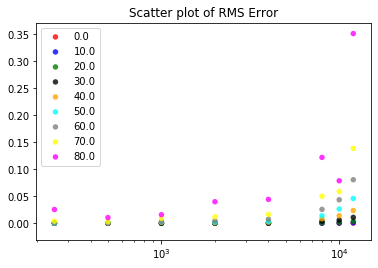

In [11]:
L = np.arange(0., 91.0, 10.)
CFs = [250., 500., 1000., 2000., 4000., 8000., 10000., 12000.] 

dur = 102.4e-3 # 2048 samples
window_len = int(fs * dur)
CF_TL = np.loadtxt('tlmodel/cf.txt') 

################# TL ##########################################
t = np.arange(0., dur, 1./fs_tl)
hanlength = int(10e-3 * fs_tl) 

# initialize an empty array for storing all the excitation patterns
y_bm_tl_all = np.zeros((len(L)*len(CFs), len(CF_TL)))
tl_pred_all= np.zeros((len(L)*len(CFs), window_len, len(CF_TL))) # to store all prediction ouputs

for idx, f_tone in enumerate(CFs):
    stim_sin = np.sin(2 * np.pi * f_tone * t)
    han = signal.hanning(hanlength)
    stim_sin[:int(hanlength/2)] = stim_sin[:int(hanlength/2)] * han[:int(hanlength/2)]
    stim_sin[-int(hanlength/2):] = stim_sin[-int(hanlength/2):] * han[int(hanlength/2):]
    total_length_tl = factor_fs * (window_len + right_context + left_context)
    stim = np.zeros((len(L), total_length_tl))
    for j in range(len(L)):
        stim[j, factor_fs*right_context:factor_fs*(window_len+right_context)] = p0 * np.sqrt(2) * 10**(L[j]/20) * stim_sin
    
    output = tl_vbm_and_oae(stim, L)

    tl_target_tone_full = np.zeros((len(L), total_length_tl,channels_tl))
    tl_target_tone = np.zeros((len(L), window_len,channels))
    stimrange = range(right_context*factor_fs, (right_context*factor_fs) + (factor_fs*samples))
    for i in range(len(L)):
        tl_target_tone_full[i,:,:] = np.array(output[i]['v'])
        tl_target_tone[i,:,:] = sp_sig.resample_poly(output[i]['v'][stimrange,::down_rate], fs, fs_tl)
        tl_target_tone[i,:,:] = tl_target_tone[i,:,:] * 1e6  
    tl_target_tone_rms = np.vstack([rms(tl_target_tone[i]) for i in range(len(L))])
    
    y_bm_tl_all[ idx*len(L):(idx+1)*len(L) , :] = tl_target_tone_rms
    tl_pred_all[idx*len(L):(idx+1)*len(L) , :, :] = tl_target_tone
    
################# CoNNear ####################################
t = np.arange(0., dur, 1./fs)
hanlength = int(10e-3 * fs)

# initialize an empty array for storing all the excitation patterns
y_bm_connear_all = np.zeros((len(L)*len(CFs), len(CF_TL))) 
connear_pred_all= np.zeros((len(L)*len(CFs), window_len, len(CF_TL))) # to store all prediction ouputs

for idx, f_tone in enumerate(CFs):
    stim_sin = np.sin(2 * np.pi * f_tone * t)
    han = signal.windows.hann(hanlength)
    stim_sin[:int(hanlength/2)] = stim_sin[:int(hanlength/2)] * han[:int(hanlength/2)]
    stim_sin[-int(hanlength/2):] = stim_sin[-int(hanlength/2):] * han[int(hanlength/2):]
    stim = np.zeros((len(L), int(len(stim_sin))))
    total_length = window_len + right_context + left_context 
    stim = np.zeros((len(L), total_length))
    for j in range(len(L)):
        stim[j,right_context:window_len+right_context] = p0 * np.sqrt(2) * 10**(L[j]/20) * stim_sin
    
    # prepare for feeding to the DNN
    stim = np.expand_dims(stim, axis=2)

    connear_pred_tone = connear.predict(stim, verbose=1)
    bmm_tone_connear = connear_pred_tone
    bmm_tone_connear.shape
    connear_pred_tone_rms = np.vstack([rms(bmm_tone_connear[i]) for i in range(len(L))])
  
    y_bm_connear_all[ idx*len(L):(idx+1)*len(L) , :] = connear_pred_tone_rms
    connear_pred_all[idx*len(L):(idx+1)*len(L) , :, :] = bmm_tone_connear
    
################ Plots ######################################
L2Loss = [[] for _ in L]
cf_index = -1
for row in range(len(CFs) * len(L)):
    level_index = row % len(L)
    if level_index == 0:
        cf_index += 1
    l2_loss = np.sqrt(np.mean(np.square(y_bm_connear_all[row,:] - y_bm_tl_all[row,:])))
    cf = CFs[cf_index]
    L2Loss[level_index].append([cf, l2_loss])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
colors=['red', 'blue', 'green', 'black', 'orange', 'cyan','gray','yellow','magenta']

for data, color, level in zip(L2Loss, colors, L):
    x = []
    y = []
    for x_, y_ in data:
        x.append(x_)
        y.append(y_)
    ax.scatter(x, y, alpha=0.8, color=color, edgecolors='none', s=30, label=level)
    ax.set_xscale('log')
    
plt.title('Scatter plot of RMS Error')
plt.legend(loc="upper left")
plt.show()